In [1]:
import pandas as pd
import numpy as np
import warnings

# Suppress all runtime warnings (e.g., divide by zero, overflow)
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(all='ignore')


cars_DecisionTree = pd.read_parquet("cars_ready_DecisionTree_small.parquet")
print("Price" in cars_DecisionTree.columns)
print(cars_DecisionTree.columns.tolist())




False
['Mileage', 'Log_Mileage', 'Age', 'Log_Age', 'Mileage_per_Year', 'Engine_Power', 'Engine_Capacity', 'Power_per_Liter', 'No_Accidents', 'Service_Record', 'Is_Imported', 'First_Owner', 'Professional_Seller', 'Make', 'Make_Model', 'Body_Type', 'Fuel_Type', 'Gearbox', 'Transmission', 'Equipment_Safety_ABS', 'Equipment_Safety_Poduszka_powietrzna_pasażera', 'Equipment_Safety_Poduszka_powietrzna_kierowcy', 'Equipment_Comfort_and_Extras_Elektryczne_szyby_przednie', 'Equipment_Audio_and_Multimedia_Radio', 'Equipment_Safety_ESP', 'Equipment_Safety_Boczne_poduszki_powietrzne_-_przód', 'Equipment_Safety_Isofix_(punkty_mocowania_fotelika_dziecięcego)', 'Equipment_Driver_Assistance_Systems_Podgrzewane_lusterka_boczne', 'Equipment_Comfort_and_Extras_Kierownica_skórzana', 'Equipment_Safety_Kurtyny_powietrzne_-_przód', 'Equipment_Driver_Assistance_Systems_Wspomaganie_kierownicy', 'Equipment_Driver_Assistance_Systems_Lusterka_boczne_ustawiane_elektrycznie', 'Equipment_Driver_Assistance_Systems_Kon

In [2]:
pd.set_option('display.max_columns', None)
cars_DecisionTree.head()

,Mileage,Log_Mileage,Age,Log_Age,Mileage_per_Year,Engine_Power,Engine_Capacity,Power_per_Liter,No_Accidents,Service_Record,Is_Imported,First_Owner,Professional_Seller,Make,Make_Model,Body_Type,Fuel_Type,Gearbox,Transmission,Equipment_Safety_ABS,Equipment_Safety_Poduszka_powietrzna_pasażera,Equipment_Safety_Poduszka_powietrzna_kierowcy,Equipment_Comfort_and_Extras_Elektryczne_szyby_przednie,Equipment_Audio_and_Multimedia_Radio,Equipment_Safety_ESP,Equipment_Safety_Boczne_poduszki_powietrzne_-_przód,Equipment_Safety_Isofix_(punkty_mocowania_fotelika_dziecięcego),Equipment_Driver_Assistance_Systems_Podgrzewane_lusterka_boczne,Equipment_Comfort_and_Extras_Kierownica_skórzana,Equipment_Safety_Kurtyny_powietrzne_-_przód,Equipment_Driver_Assistance_Systems_Wspomaganie_kierownicy,Equipment_Driver_Assistance_Systems_Lusterka_boczne_ustawiane_elektrycznie,Equipment_Driver_Assistance_Systems_Kontrola_trakcji,Equipment_Comfort_and_Extras_Elektryczne_szyby_tylne,Equipment_Audio_and_Multimedia_Gniazdo_USB,Equipment_Comfort_and_Extras_Podłokietniki_-_przód,Equipment_Comfort_and_Extras_Kierownica_wielofunkcyjna,Equipment_Audio_and_Multimedia_Interfejs_Bluetooth,Equipment_Comfort_and_Extras_Czujnik_deszczu,Equipment_Driver_Assistance_Systems_Lampy_przeciwmgielne,Equipment_Driver_Assistance_Systems_Kontrola_odległości_z_tyłu_(przy_parkowaniu),Equipment_Comfort_and_Extras_Kierownica_ze_sterowaniem_radia,Equipment_Safety_System_wspomagania_hamowania,Equipment_Driver_Assistance_Systems_Tempomat,Equipment_Driver_Assistance_Systems_Czujnik_zmierzchu,Equipment_Driver_Assistance_Systems_Elektroniczna_kontrola_ciśnienia_w_oponach,Equipment_Audio_and_Multimedia_Zestaw_głośnomówiący,Equipment_Comfort_and_Extras_Podgrzewany_fotel_kierowcy,Equipment_Comfort_and_Extras_Tapicerka_materiałowa,Equipment_Driver_Assistance_Systems_Wspomaganie_ruszania_pod_górę-_Hill_Holder,Equipment_Comfort_and_Extras_Podgrzewany_fotel_pasażera,Equipment_Driver_Assistance_Systems_Światła_do_jazdy_dziennej_diodowe_LED,Equipment_Comfort_and_Extras_Przyciemniane_tylne_szyby,Equipment_Driver_Assistance_Systems_System_Start/Stop,Equipment_Comfort_and_Extras_Podłokietniki_-_tył,Equipment_Audio_and_Multimedia_System_nawigacji_satelitarnej,Equipment_Driver_Assistance_Systems_Światła_do_jazdy_dziennej,Equipment_Driver_Assistance_Systems_Lusterka_boczne_składane_elektrycznie,Equipment_Safety_Kurtyny_powietrzne_-_tył,Equipment_Safety_Elektroniczny_system_rozdziału_siły_hamowania,Equipment_Driver_Assistance_Systems_Kontrola_odległości_z_przodu_(przy_parkowaniu),Equipment_Safety_Boczna_poduszka_powietrzna_kierowcy,Equipment_Comfort_and_Extras_Dźwignia_zmiany_biegów_wykończona_skórą,Equipment_Driver_Assistance_Systems_Kamera_parkowania_tył,Equipment_Audio_and_Multimedia_Ekran_dotykowy,Equipment_Audio_and_Multimedia_System_nagłośnienia,Equipment_Driver_Assistance_Systems_Lampy_tylne_w_technologii_LED,Equipment_Comfort_and_Extras_Klimatyzacja_automatyczna,Equipment_Comfort_and_Extras_Wycieraczki,Log_Price,cv_fold,split,desc_pca_0,desc_pca_1,desc_pca_2,desc_pca_3,desc_pca_4,desc_pca_5,desc_pca_6,desc_pca_7,desc_pca_8,desc_pca_9,desc_pca_10,desc_pca_11,desc_pca_12,desc_pca_13,desc_pca_14,desc_pca_15,desc_pca_16,desc_pca_17,desc_pca_18,desc_pca_19,desc_pca_20,desc_pca_21,desc_pca_22,desc_pca_23,desc_pca_24,desc_pca_25,desc_pca_26,desc_pca_27,desc_pca_28,desc_pca_29,desc_pca_30,desc_pca_31,desc_pca_32,desc_pca_33,desc_pca_34,desc_pca_35,desc_pca_36,desc_pca_37,desc_pca_38,desc_pca_39,desc_pca_40,desc_pca_41,desc_pca_42,desc_pca_43,desc_pca_44,desc_pca_45,desc_pca_46,desc_pca_47,desc_pca_48,desc_pca_49
0,-0.023098,0.276176,0.541434,0.676855,-0.497607,0.529684,0.104441,0.853877,1,1,1,0,0,10.656807,10.399174,10.409672,10.703618,10.240137,10.508585,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,10.594157,0,train,-0.528191,1.971936,2.024133,1.780874,0.436160,0.849286,-0.170133,-0.611332,0.278231,-1.923361,3.151215,1.380033,-0.253969,-1.116240,-0.40673

In [3]:
# --- Importy ---
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from rtdl import FTTransformer, FeatureTokenizer, Transformer
from joblib import Parallel, delayed

# --- Ustawienia ---
DEBUG = False
SIZE = 0.001
EPOCHS = 25
PATIENCE = 5
BATCH_SIZE = 1024
d_token = 96
N_JOBS = 1
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# --- Urządzenie ---
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {DEVICE}")

# --- Dane ---
df = cars_DecisionTree
train_df = df[df["cv_fold"] != -1].dropna()
test_df = df[df["cv_fold"] == -1].dropna()

X_train = train_df.drop(columns=["Log_Price", "cv_fold", "split"]).astype(np.float32).values
y_train = train_df["Log_Price"].astype(np.float32).values
X_test = test_df.drop(columns=["Log_Price", "cv_fold", "split"]).astype(np.float32).values
y_test = test_df["Log_Price"].astype(np.float32).values

if DEBUG:
    X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=SIZE, random_state=SEED)
    X_test, _, y_test, _ = train_test_split(X_test, y_test, train_size=SIZE, random_state=SEED)
    print(f"⚠️ DEBUG MODE: Using only {SIZE*100:.1f}% of training data → {X_train.shape}")

n_num_features = X_train.shape[1]
cat_cardinalities = []

# --- Model builder ---
def build_model():
    tokenizer = FeatureTokenizer(
        n_num_features=n_num_features,
        cat_cardinalities=cat_cardinalities,
        d_token=d_token
    )
    transformer = Transformer(
        d_token=d_token,
        n_blocks=2,
        attention_n_heads=2,
        attention_dropout=0.1,
        attention_initialization="kaiming",
        attention_normalization=nn.LayerNorm,
        ffn_d_hidden=192,
        ffn_dropout=0.1,
        ffn_activation=nn.ReLU,
        ffn_normalization=nn.LayerNorm,
        residual_dropout=0.0,
        prenormalization=True,
        first_prenormalization=False,
        last_layer_query_idx=[-1],
        n_tokens=n_num_features + 1,
        kv_compression_ratio=0.5,
        kv_compression_sharing="key-value",
        head_activation=nn.Identity,
        head_normalization=nn.LayerNorm,
        d_out=1
    )
    return FTTransformer(tokenizer, transformer).to(DEVICE)

# --- Trening folda z early stoppingiem ---
def train_fold(i, train_idx, val_idx):
    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_val, y_val = X_train[val_idx], y_train[val_idx]

    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    best_rmse = float('inf')
    epochs_no_improve = 0

    for epoch in range(EPOCHS):
        print(f"[Fold {i}] Epoch {epoch+1}/{EPOCHS}")
        model.train()
        idx = np.random.permutation(len(X_tr))
        X_tr, y_tr = X_tr[idx], y_tr[idx]

        for start in range(0, len(X_tr), BATCH_SIZE):
            end = start + BATCH_SIZE
            xb = torch.tensor(X_tr[start:end], dtype=torch.float32).to(DEVICE)
            yb = torch.tensor(y_tr[start:end], dtype=torch.float32).unsqueeze(1).to(DEVICE)

            optimizer.zero_grad()
            y_pred = model(xb, None)
            loss = loss_fn(y_pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            Xv = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
            y_pred_val = model(Xv, None).cpu().numpy().flatten()
            rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

        if rmse_val < best_rmse:
            best_rmse = rmse_val
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= PATIENCE:
            print(f"⏹️ Early stopping triggered at epoch {epoch+1}")
            break

    mae = mean_absolute_error(y_val, y_pred_val)
    r2 = r2_score(y_val, y_pred_val)
    print(f"Fold {i}: MAE={mae:.4f}, RMSE={rmse_val:.4f}, R2={r2:.4f}")
    return mae, rmse_val, r2

# --- Cross-validation ---
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
splits = list(kf.split(X_train))

results = Parallel(n_jobs=N_JOBS)(
    delayed(train_fold)(i, train_idx, val_idx)
    for i, (train_idx, val_idx) in enumerate(splits)
)

mae_cv, rmse_cv, r2_cv = zip(*results)
print("\n📊 Cross-validation summary:")
print(f"MAE: {np.mean(mae_cv):.4f} ± {np.std(mae_cv):.4f}")
print(f"RMSE: {np.mean(rmse_cv):.4f} ± {np.std(rmse_cv):.4f}")
print(f"R2: {np.mean(r2_cv):.4f} ± {np.std(r2_cv):.4f}")

# --- Finalny trening bez early stoppingu ---
model_final = build_model()
optimizer = torch.optim.Adam(model_final.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

model_final.train()
for epoch in range(EPOCHS):
    print(f"[Final Training] Epoch {epoch+1}/{EPOCHS}")
    idx = np.random.permutation(len(X_train))
    X_train, y_train = X_train[idx], y_train[idx]
    for start in range(0, len(X_train), BATCH_SIZE):
        end = start + BATCH_SIZE
        xb = torch.tensor(X_train[start:end], dtype=torch.float32).to(DEVICE)
        yb = torch.tensor(y_train[start:end], dtype=torch.float32).unsqueeze(1).to(DEVICE)

        optimizer.zero_grad()
        y_pred = model_final(xb, None)
        loss = loss_fn(y_pred, yb)
        loss.backward()
        optimizer.step()

# --- Test końcowy ---
model_final.eval()
with torch.no_grad():
    Xtt = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
    y_test_pred = model_final(Xtt, None).cpu().numpy().flatten()

print("\n✅ Final test set performance:")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")
print(f"R2: {r2_score(y_test, y_test_pred):.4f}")

✅ Using device: mps
[Fold 0] Epoch 1/25
[Fold 0] Epoch 2/25
[Fold 0] Epoch 3/25
[Fold 0] Epoch 4/25
[Fold 0] Epoch 5/25
[Fold 0] Epoch 6/25
[Fold 0] Epoch 7/25
[Fold 0] Epoch 8/25
[Fold 0] Epoch 9/25
[Fold 0] Epoch 10/25
[Fold 0] Epoch 11/25
[Fold 0] Epoch 12/25
[Fold 0] Epoch 13/25
[Fold 0] Epoch 14/25
[Fold 0] Epoch 15/25
⏹️ Early stopping triggered at epoch 15
Fold 0: MAE=0.1718, RMSE=0.2410, R2=0.9329
[Fold 1] Epoch 1/25
[Fold 1] Epoch 2/25
[Fold 1] Epoch 3/25
[Fold 1] Epoch 4/25
[Fold 1] Epoch 5/25
[Fold 1] Epoch 6/25
[Fold 1] Epoch 7/25
[Fold 1] Epoch 8/25
[Fold 1] Epoch 9/25
[Fold 1] Epoch 10/25
[Fold 1] Epoch 11/25
[Fold 1] Epoch 12/25
[Fold 1] Epoch 13/25
[Fold 1] Epoch 14/25
[Fold 1] Epoch 15/25
[Fold 1] Epoch 16/25
[Fold 1] Epoch 17/25
[Fold 1] Epoch 18/25
[Fold 1] Epoch 19/25
[Fold 1] Epoch 20/25
[Fold 1] Epoch 21/25
⏹️ Early stopping triggered at epoch 21
Fold 1: MAE=0.1583, RMSE=0.2287, R2=0.9392
[Fold 2] Epoch 1/25
[Fold 2] Epoch 2/25
[Fold 2] Epoch 3/25
[Fold 2] Epoch 4

In [4]:
# Calculate test set metrics using the correct variable name
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

# --- Zbuduj DataFrame z wynikami FT-Transformer ---
ft_transformer_results = pd.DataFrame({
    "MAE_CV": [np.mean(mae_cv)],
    "RMSE_CV": [np.mean(rmse_cv)],
    "R2_CV": [np.mean(r2_cv)],
    "MAE_Test": [mae_test],
    "RMSE_Test": [rmse_test],
    "R2_Test": [r2_test]
}, index=["FT-Transformer"]).round(4)

# --- Wyświetl tabelę ---
print("\n📊 FT-Transformer Cross-validation and test set performance:")
print(ft_transformer_results.to_string())


📊 FT-Transformer Cross-validation and test set performance:
                MAE_CV  RMSE_CV   R2_CV  MAE_Test  RMSE_Test  R2_Test
FT-Transformer  0.1636   0.2304  0.9384    0.1576     0.2228   0.9423


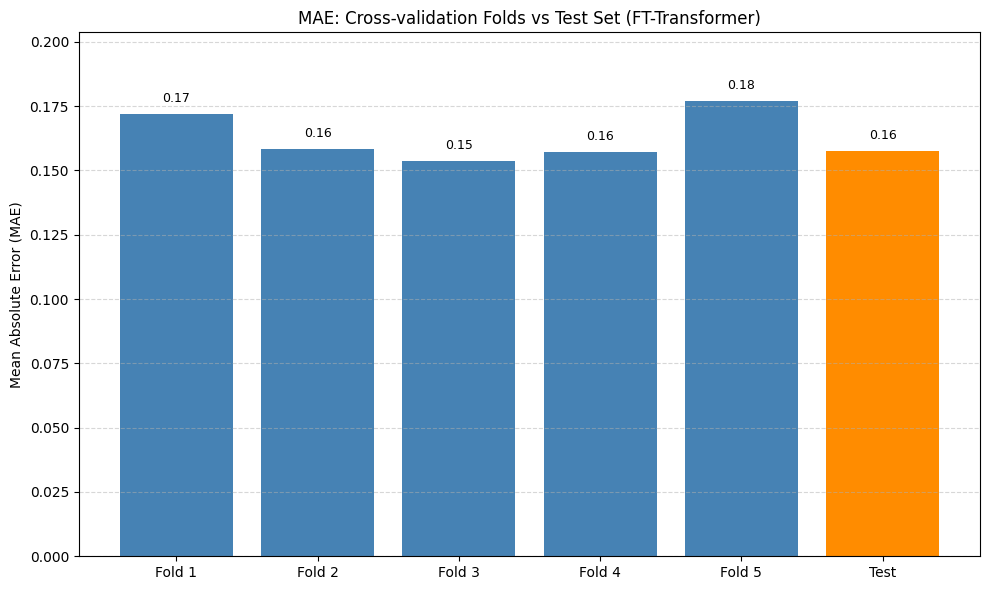

In [5]:
# --- Wykres MAE: Cross-validation folds vs Test Set (skala dopasowana) ---
import matplotlib.pyplot as plt

mae_test = mean_absolute_error(y_test, y_test_pred)
mae_all = list(mae_cv) + [mae_test]

plt.figure(figsize=(10, 6))
bars = plt.bar([f"Fold {i+1}" for i in range(len(mae_cv))] + ["Test"],
               mae_all,
               color=["steelblue"] * len(mae_cv) + ["darkorange"])

plt.title("MAE: Cross-validation Folds vs Test Set (FT-Transformer)")
plt.ylabel("Mean Absolute Error (MAE)")

# Automatyczne dopasowanie osi Y z marginesem 10%
y_max = max(mae_all)
plt.ylim(0, y_max * 1.15)

# Dodanie etykiet na słupkach
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + y_max * 0.02,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [6]:
import pandas as pd

df_metrics = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(5)] + ["Test"],
    "MAE": list(mae_cv) + [mean_absolute_error(y_test, y_test_pred)],
    "RMSE": list(rmse_cv) + [np.sqrt(mean_squared_error(y_test, y_test_pred))],
    "R2": list(r2_cv) + [r2_score(y_test, y_test_pred)]
})
print(df_metrics.round(4))

     Fold     MAE    RMSE      R2
0  Fold 1  0.1718  0.2410  0.9329
1  Fold 2  0.1583  0.2287  0.9392
2  Fold 3  0.1537  0.2182  0.9442
3  Fold 4  0.1572  0.2254  0.9414
4  Fold 5  0.1771  0.2387  0.9341
5    Test  0.1576  0.2228  0.9423


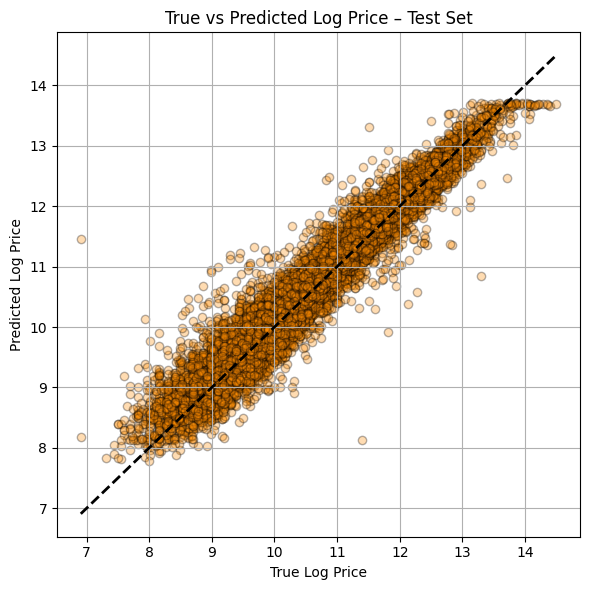

In [7]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3, color="darkorange", edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("True Log Price")
plt.ylabel("Predicted Log Price")
plt.title("True vs Predicted Log Price – Test Set")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import torch
print(torch.backends.mps.is_available())

True
